# pycobra and scikit-learn

This notebook demonstrates pycobras integration with the scikit-learn ecosystem.
We will also give an example of pycobra's performance on some real world data-sets.

In [1]:
from pycobra.cobra import Cobra
from pycobra.ewa import Ewa
from pycobra.diagnostics import Diagnostics
from pycobra.visualisation import Visualisation
import numpy as np
%matplotlib inline

Let's set up a synthetic data-set just to show that the COBRA estimator is scikit-learn compatible.

In [2]:
# setting up our random data-set
rng = np.random.RandomState(1)

# D1 = train machines; D2 = create COBRA; D3 = calibrate epsilon, alpha; D4 = testing
n_features = 20
D1, D2, D3, D4 = 200, 200, 200, 200
D = D1 + D2 + D3 + D4
X = rng.uniform(-1, 1, D * n_features).reshape(D, n_features)
Y = np.power(X[:,1], 2) + np.power(X[:,3], 3) + np.exp(X[:,10]) 
# Y = np.power(X[:,0], 2) + np.power(X[:,1], 3)

# training data-set
X_train = X[:D1 + D2]
X_test = X[D1 + D2 + D3:D1 + D2 + D3 + D4]
X_eps = X[D1 + D2:D1 + D2 + D3]
# for testing
Y_train = Y[:D1 + D2]
Y_test = Y[D1 + D2 + D3:D1 + D2 + D3 + D4]
Y_eps = Y[D1 + D2:D1 + D2 + D3]

Similar to other scikit-learn estimators, we set up our machine by creating an object and then fitting it. 
Since we are not passing an Epsilon value, we pass data to find an optimal epsilon value while instantiating our object. The optimal epsilon is found through the scikit-learn `CVGridSearch`. The `grid_points` parameter decides how many possible epsilon values must be traversed.

In [3]:
cobra = Cobra(X_epsilon=X_eps, y_epsilon=Y_eps, grid_points=5)

In [4]:
cobra.fit(X_train, Y_train)

Cobra(X_epsilon=None, epsilon=0.768427354440673, grid_points=None,
   random_state=None, y_epsilon=None)

We now see if our object can fit into the scikit-learn pipeline and GridSearch - and it can!

In [5]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(Cobra) #passes

### Exponentially Weighted Average Aggregate

Let us also demonstrate the EWA predictor. You can read more about it over here in the [paper](http://www.crest.fr/ckfinder/userfiles/files/pageperso/tsybakov/DTcolt2007.pdf) by A. Dalalyan and A. B. Tsybakov. 

In [6]:
ewa = Ewa(X_beta=X_eps, y_beta=Y_eps)

If we fit EWA without passing beta, we perform a CV to find the optimal beta.

In [7]:
ewa.fit(X_train, Y_train)

Ewa(X_beta=None, beta=0.5, betas=None, random_state=None, y_beta=None)

In [8]:
check_estimator(Ewa) #passes

EWA assigns weights to each machine based on it's MSE. We can check the weights of each machine with the `plot_machine_weights` method.

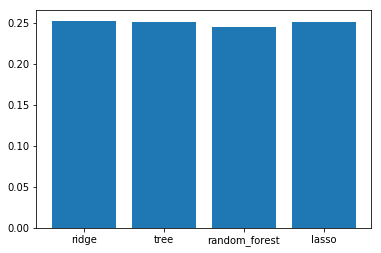

In [9]:
ewa.plot_machine_weights()

In [10]:
ewa.machine_weight

{'lasso': 0.25133666855746867,
 'random_forest': 0.24512681538048711,
 'ridge': 0.25266558932645794,
 'tree': 0.25087092673558631}

Like the Cobra estimator, Ewa is also a scikit-learn compatible estimator. It also fits into the Visualisation class, like demonstrated in the [notebook](https://github.com/bhargavvader/pycobra/blob/master/notebooks/visualise.ipynb). 

### Predicting?

Like the other scikit-learn predictors, we estimate on data by simply using the `predict()` method.

In [11]:
query = X_test[0].reshape(1, -1)

In [12]:
cobra.predict(query)

array([ 0.7317809])

In [13]:
ewa.predict(query)

array([ 0.60595275])

### Why pycobra?

There are scikit-learn estimators which already perform well in basic regression tasks - why use pycobra?
The Cobra estimator has the advantage of a theoretical bound on its performance - this means it is supposed to perform at least as well as the estimators used to create it, up to a remainder term which decays to zero. The Ewa estimator also benefits from similar bounds.

pycobra also lets you compare the scikit-learn estimators used in the aggregation - unlike the ensemble methods for regression which scikit-learn has, pycobra's algorithms is actually built on other scikit-learn like estimators. 

### pycobra for classification

pycobra also implements the classification algorithm as introduced by Mojirsheibani [1999] Combining Classifiers via Discretization, Journal of the American Statistical Association. 

ClassifierCobra operates exactly as COBRA in the sense that data points are selected with respect to their closeness to the prediction of the new query point. Then, instead of forming a weighted average as COBRA, ClassifierCobra performs a majority vote to assign a label to the new point.

In [14]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
bc = datasets.load_breast_cancer()
X = bc.data[:-20]
y = bc.target[:-20]
X_test = bc.data[-20:]
y_test = bc.target[-20:]

In [15]:
from pycobra.classifiercobra import ClassifierCobra
check_estimator(ClassifierCobra)

In [16]:
cc = ClassifierCobra()

In [17]:
cc.fit(X, y)

ClassifierCobra(random_state=None)

In [18]:
cc.predict(X_test)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.])

Let's see how it works in a practical case.

In [19]:
cc_diag = Diagnostics(cc, X_test, y_test)

In [20]:
cc_diag.load_errors()

In [21]:
cc_diag.machine_error

{'ClassifierCobra': 0.0,
 'knn': 0.0,
 'sgd': 0.099999999999999978,
 'svm': 0.30000000000000004,
 'tree': 0.0}

Quite well!

### Real-world datasets

We have demonstrated in the regression notebook how pycobra works on synthetic data-sets. Let's see pycobra in action on some scikit-learn regression datasets.

In [22]:
diabetes = datasets.load_diabetes()

diabetes_X_train = diabetes.data[:-40]
diabetes_X_test = diabetes.data[-20:]
# part of the data to find an appropriate epsilon
diabetes_X_eps = diabetes.data[-40:-20]

diabetes_y_train = diabetes.target[:-40]
diabetes_y_test = diabetes.target[-20:]
diabetes_y_eps = diabetes.target[-40:-20]

We're unaware of what epsilon value to choose for our data-sets so by passing `X_eps` and `y_eps` we can get an idea of what might be a good epsilon value. 

In [23]:
COBRA_diabetes = Cobra(X_epsilon=diabetes_X_eps, y_epsilon=diabetes_y_eps, grid_points=50)
COBRA_diabetes.fit(diabetes_X_train, diabetes_y_train)

Cobra(X_epsilon=None, epsilon=74.571428571428584, grid_points=None,
   random_state=None, y_epsilon=None)

Predicting using the COBRA predictor is again similar to using a scikit-learn estimator.

In [24]:
COBRA_diabetes.predict(diabetes_X_test)

array([ 167.37142857,  125.9296875 ,  169.97435897,  126.75308642,
        196.6969697 ,  123.31355932,  230.75      ,  111.14130435,
        117.90322581,  117.81372549,  230.71428571,  104.26865672,
        114.35294118,  112.62195122,  104.7761194 ,  182.14035088,
        110.65882353,  121.53846154,  176.63793103,  104.68181818])

Let's compare our MSEs using the diagnostics class now.

In [25]:
cobra_diagnostics = Diagnostics(COBRA_diabetes, diabetes_X_test, diabetes_y_test, load_MSE=True)

In [26]:
cobra_diagnostics.machine_MSE

{'COBRA': 2537.4220013613308,
 'lasso': 1890.4566824060098,
 'random_forest': 2699.364,
 'ridge': 2046.7959296145473,
 'tree': 4174.1999999999998}

Let us similarily use COBRA on the Boston housing data set.

In [27]:
boston = datasets.load_boston()

boston_X_train = boston.data[:-40]
boston_X_test = boston.data[-20:]
boston_X_eps = boston.data[-40:-20]

boston_y_train = boston.target[:-40]
boston_y_test = boston.target[-20:]
boston_y_eps = boston.target[-40:-20]

In [28]:
COBRA_boston = Cobra(X_epsilon=boston_X_eps, y_epsilon=boston_y_eps, grid_points=50)
COBRA_boston.fit(boston_X_train, boston_y_train)

/Users/bhargavvader/open_source/pycobra/venv/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Cobra(X_epsilon=None, epsilon=7.1981878724376198, grid_points=None,
   random_state=None, y_epsilon=None)

In [29]:
cobra_diagnostics = Diagnostics(COBRA_boston, boston_X_test, boston_y_test, load_MSE=True)

In [30]:
cobra_diagnostics.machine_MSE

{'COBRA': 35.463843231172476,
 'lasso': 17.055321704329554,
 'random_forest': 19.653374999999993,
 'ridge': 19.601633683218243,
 'tree': 21.206499999999998}